An **index** is a special data structure that enhances the speed of data retrieval from a table, at the cost of additional writes and storage required to maintain it. 

It gives a quick way to locate rows inside a table without scanning the entire table.

You can think of an index like the **index pages of a book**. Instead of reading every page to find a topic, you simply check the index, which points you directly to the page you need. PostgreSQL uses indexes in the same way to find data quickly.

Without an **index**, PostgreSQL must scan the entire table to find a specific row. If the table contains many rows, this becomes slow, just like reading a whole book to find a single line. However, with an index defined based on a column, PostgreSQL can locate the matching rows much faster.

**Use the `EXPLAIN` statement to explain a query.**
```postgresql
EXPLAIN sql_query;
```

# Types of PostgreSQL indexes

PostgreSQL offers various index types, each designed to cater to specific data scenarios and query patterns.

By understanding these index types, you can enhance the query performance more effectively.

**B-tree index**
* B-tree is the default index type in PostgreSQL.
* B-tree stands for balanced tree.
* B-tree indexes maintain the sorted values, making them efficient for exact matches and range queries.

**Hash index**
* Hash indexes maintain a 32-bit hash code created from values of the indexed columns.
* Therefore, hash indexes can only handle simple equality comparisons (=).

**GIN index**
* GIN indexes are inverted indexes that are suitable for composite values such as arrays, JSONB data, and full-text search.
* Since a GIN index stores a separate entry for each component, it can handle queries that check for the existence of a specific component.

**GiST index**
* GiST indexes are versatile and support a wide range of data types, including geometric and full-text data.
* GiST indexes allow various search strategies such as nearest-neighbor and partial match searches, making them useful for specialized applications.

**SP-GiST index**
* SP-GiST indexes are useful for indexing data with hierarchical structures or complex data types.
* SP-GiST indexes partition the index space into non-overlapping regions, offering efficient search capabilities for specialized data structures.

**BRIN (Block Range Index) index**
* BRIN indexes are designed for very large tables where indexing every row is impractical.
* A BRIN index divides the table into ranges of pages and stores summarized information about each range, making it efficient for range queries on large datasets while using minimal space.

# CREATE INDEX statement

**SYNTAX**
```postgresql
CREATE INDEX [IF NOT EXISTS] index_name
ON table_name(column1, column2, ...);
```
In this syntax:
* First, specify the index name after the `CREATE INDEX` clause.
* Second, use the `IF NOT EXISTS` option to prevent an error if the index already exists.
* Third, provide the **table name** to which the index belongs.
* Finally, list out one or more indexed columns inside the `()` after the table name.

Note that the syntax of the `CREATE INDEX` statement is more complex than this, having additional features such as **unique indexes**, **indexes on expressions**, **partial indexes**, and **multicolumn indexes**.

By default, the `CREATE INDEX` statement creates a **B-tree index**, which is appropriate for most cases.

When you run the `CREATE INDEX` statement:
* PostgreSQL scans the table, extracts all values from the column(s), and stores them in the index data structure.
* This process is called an **index build**.
* This process may take some time if the table contains many rows, similar to how building a book’s index takes longer for a thicker book.

By default, PostgreSQL allows `SELECT` operations while creating the index, but it blocks `INSERT`, `UPDATE`, and `DELETE` operations during that time for safety.

As an alternative, if you don't want to block `INSERT`, `UPDATE`, or `DELETE` operations during index creation, you can use the syntax `CREATE INDEX CONCURRENTLY` to create the index without blocking, but at a much slower rate.

**After the index is created, PostgreSQL must keep it synchronized with the table.**
* For example, when inserting, updating, or deleting rows in the `contacts` table, PostgreSQL also updates the index so that it remains accurate.
* Because of this, **indexes improve read speed** but add a bit of **overhead to write operations** (inserts, updates, deletes) — similar to how updating a book’s content also requires updating its index.

# UNIQUE index

The PostgreSQL unique index enforces the uniqueness of values in one or multiple columns.

To create a unique index, you use the following `CREATE UNIQUE INDEX` statement:
```postgresql
CREATE UNIQUE INDEX index_name
ON table_name (column [, ...])
[ NULLS [ NOT ] DISTINCT ];
```
* The `NULL NOT DISTINCT` option treats nulls as equal, whereas `NULLS DISTINCT` treats nulls as distinct values.
* By default, the statement uses `NULLS DISTINCT`, meaning that the indexed column may contain multiple nulls.

PostgreSQL offers multiple index types, but only the **B-tree index type** supports **unique indexes**.
* When you define a unique index for a column, the **column cannot store multiple rows with the same values**.
* If you define a unique index for two or more columns, the **combined values in these columns cannot be duplicated in multiple rows**.
* When you define a **primary key** or a **unique constraint** for a table, PostgreSQL automatically creates a corresponding unique index.

## Unique indexes for a primary key column and a column with a unique constraint

```postgresql
CREATE TABLE employees (
    employee_id SERIAL PRIMARY KEY,
    first_name VARCHAR(255) NOT NULL,
    last_name VARCHAR(255) NOT NULL,
    email VARCHAR(255) UNIQUE,
    mobile_phone VARCHAR(20),
    work_phone VARCHAR(20),
    phone_extension VARCHAR(5)
); 
```
In this statement, the `employee_id` is the **primary key** column, and the `email` column has a **unique constraint**; therefore, PostgreSQL creates two `UNIQUE` indexes, one for each column.

**Show the indexes of the `employees` table:**
```postgresql
SELECT
    tablename,
    indexname,
    indexdef
FROM
    pg_indexes
WHERE
    tablename = 'employees'; 
```
**OUTPUT**
```
tablename |      indexname      |                                     indexdef
-----------+---------------------+----------------------------------------------------------------------------------
 employees | employees_pkey      | CREATE UNIQUE INDEX employees_pkey ON public.employees USING btree (employee_id)
 employees | employees_email_key | CREATE UNIQUE INDEX employees_email_key ON public.employees USING btree (email)
(2 rows)
```

## Using PostgreSQL UNIQUE index for single column

**Create a unique index on the `mobile_phone` column of the employees table:**
```postgresql
CREATE UNIQUE INDEX idx_employees_mobile_phone
ON employees(mobile_phone); 
```

PostgreSQL issues the following error if we try to insert a duplicate mobile phone number, say `(408)-555-1234`:
```postgresql
ERROR:  duplicate key value violates unique constraint "idx_employees_mobile_phone"
DETAIL:  Key (mobile_phone)=((408)-555-1234) already exists.
```

## Using PostgreSQL UNIQUE index for multiple columns

Multiple employees can share the same work phone number. However, they cannot have the same extension number.

To enforce this rule, you can define a **unique index** on both `work_phone` and `phone_extension` columns.

```postgresql
CREATE UNIQUE INDEX idx_employees_workphone
ON employees(work_phone, extension); 
```

# Index on Expression

* In PostgreSQL, indexes play an important role in optimizing query performance.
* Typically, you create an index that **references one or more columns** of a table.
* PostgreSQL also allows you to create an index based on an expression involving table columns.
* This type of index is called an **index on expression**.
* Note that the indexes on expressions are also known as **functional indexes**.

**SYNTAX**
```postgresql
CREATE INDEX index_name
ON table_name (expression); 
```
PostgreSQL will consider using this index when the **`expression`** appears in the `WHERE` clause or in the `ORDER BY` clause of the SQL statement.

Note that maintaining indexes on expressions can incur additional costs. 
* PostgreSQL **evaluates the expression for each row** during insertion or update and utilizes the result for building the index.
* Therefore, it’s recommended to use the indexes on expressions when prioritizing retrieval speed over insertion and update speed.

**EXAMPLE**
Define an index on an **expression** using the `CREATE INDEX` statement:
```postgresql
CREATE INDEX idx_ic_last_name
ON customer(LOWER(last_name)); 
```

Retrieve the customers based on a last name in lowercase:
```postgresql
EXPLAIN
SELECT
    customer_id,
    first_name,
    last_name
FROM
    customer
WHERE
    LOWER(last_name) = 'purdy';
```

**Output:**

```postgresql
QUERY PLAN
-------------------------------------------------------------------------------
 Bitmap Heap Scan on customer  (cost=4.30..11.15 rows=3 width=17)
   Recheck Cond: (lower((last_name)::text) = 'purdy'::text)
   ->  Bitmap Index Scan on idx_ic_last_name  (cost=0.00..4.30 rows=3 width=0)
         Index Cond: (lower((last_name)::text) = 'purdy'::text)
(4 rows)
```

Notice that PostgreSQL uses the index on the expression `idx_ic_last_name` to quickly locate the matching rows in the customer table.

# Partial Index

When you create an index on a column of a table, PostgreSQL uses all the values from that column for building the index.

Sometimes, you may want to include only some values from the indexed column in the index. 

To do that, you can use a **partial index**.
* A **partial index** is an index built on a **subset of the data** of the indexed columns.
* To define a subset of data, you use a **predicate**, which is **a conditional expression** of the partial index.
* PostgreSQL will build an index for rows that satisfy the predicate.
* This partial index can enhance query performance while reducing the index size.
* It can also improve table updates because PostgreSQL does not need to maintain the index in all cases.

To create a partial index, you use the `CREATE INDEX` statement with a `WHERE` clause:

```postgresql
CREATE [IF NOT EXISTS] INDEX index_name
ON table_name(column1, column2, ...)
WHERE predicate; 
```

**EXAMPLE**

Let’s take a look at the `customer` table from the sample database:

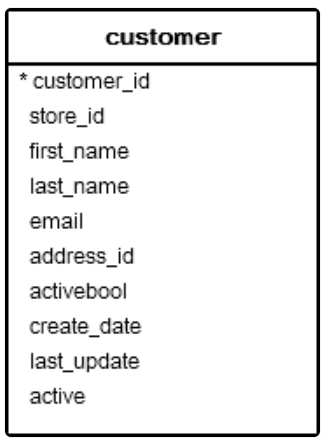

The active column has two values:
* `0`: inactive
* `1`: active

When querying data from the database, you often work with **inactive customers**, not active ones. 
* For example, you may want to follow up with inactive customers to get them back to order more films.
* To speed up the query that retrieves the inactive customer, you can create a partial index.

Create a **partial index** on the `active` column of the customer table:
```postgresql
CREATE INDEX customer_active
ON customer(active)
WHERE active = 0; 
```

Show the query plan that retrieves the **inactive** customers:
```postgresql
EXPLAIN SELECT
  *
FROM
  customer
WHERE
  active = 0; 
```

**Output:**

```postgresql
QUERY PLAN
-----------------------------------------------------------------------------------
 Index Scan using customer_active on customer  (cost=0.14..16.12 rows=15 width=70) 
```

The partial index `customer_active` improves the query performance while including the only rows that are often searched.

# Multicolumn Indexes

When you create an index on **two or more columns** within a table, this type of index is called a **multicolumn index**.
* A multicolumn index is often referred to as a **composite index**, a **combined index**, or a **concatenated index**.
* A multicolumn index can have a maximum of 32 columns.
* Additionally, only **B-tree**, **GIST**, **GIN**, and **BRIN** index types support multicolumn indexes.

**SYNTAX**
```postgresql
CREATE INDEX [IF NOT EXISTS] index_name
ON table_name(column1, column2, ...); 
```

**When defining a multicolumn index**, you should place the columns that are frequently used in the `WHERE` clause at the beginning of the column list, followed by the columns that are less frequently used in the `WHERE` clause.

In general, the query optimizer can use the index when the query’s conditions involve the index’s leading (leftmost) column. 

For example, if you have an index on `(column1, column2, column3)`, it will be considered for queries such as:
```postgresql
WHERE column1 = v1 AND column2 = v2 AND column3 = v3;
WHERE column1 = v1 AND column2 = v2;
WHERE column1 = v1;
```

* In these cases, the condition on column1 (and optionally on column2) allows PostgreSQL to efficiently narrow down the portion of the index that needs to be scanned.
* However, **if a query does not constrain the first column of the index**, PostgreSQL must evaluate whether a **full index scan on this index** is more efficient than **alternative indexes** or a **table scan**.

For instance, consider a query with only later columns in the `WHERE` clause:
```postgresql
WHERE column3 = v3;
WHERE column2 = v2 and column3 = v3;
```

Note that you can also use the `WHERE` clause **to define a partially multicolumn index** (an index on multiple columns that only includes rows satisfying a given condition).
* In such scenarios, PostgreSQL will still consider using the index, but scanning the whole index may have a higher cost than other options.
* The planner evaluates different execution paths, and if an index scan is not the most efficient, it may choose a sequential scan instead.